## NeRF: Neural Radience Field

In [4]:
!mkdir -p data
!cd data
!wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/nerf_example_data.zip
!unzip nerf_example_data.zip
!cd ..
!wget https://www.dropbox.com/s/s8j1t1wmf92jhf4/nerf-helper.py
!mv nerf-helper.py nerf_helper.py

In [9]:
! wget https://www.dropbox.com/s/s8j1t1wmf92jhf4/nerf-helper.py

--2021-12-01 11:55:45--  https://www.dropbox.com/s/s8j1t1wmf92jhf4/nerf-helper.py
Resolving www.dropbox.com (www.dropbox.com)... 162.125.71.18, 2620:100:6026:18::a27d:4612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.71.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/s8j1t1wmf92jhf4/nerf-helper.py [following]
--2021-12-01 11:55:45--  https://www.dropbox.com/s/raw/s8j1t1wmf92jhf4/nerf-helper.py
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc280a207165e50b4f52f1b8aaac.dl.dropboxusercontent.com/cd/0/inline/BbB8xv30NbtQFNVLXCWNQtSO4nk3Aubsq1ZZ_mx-eMHvSYi2jCcLELNL4a1qTGiIesjlIsUMNGUYOdVDrlspgmJvnEDnEG4HTK406heZuqKFDCxVsu4ByTpKxIoaLyPfbIrdpbAIUEJVr685-bHbf41u/file# [following]
--2021-12-01 11:55:45--  https://uc280a207165e50b4f52f1b8aaac.dl.dropboxusercontent.com/cd/0/inline/BbB8xv30NbtQFNVLXCWNQtSO4nk3Aubsq1ZZ_mx-eMHvSYi2jCcLELNL4a1qTGiIesjlIsUMNGUYOdVDr

In [5]:
# # for exrteme tpu support ! pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl
# ! pip install pytorch-lightning

In [53]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import json
import os
import pickle

import cv2
import imageio 
from PIL import Image

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
from pytorch_lightning import LightningModule, Trainer

from nerf_helper import *

### Positional encoding once again?
Where did we use positional encoding before? And what was the main reason?

Here we solve another problem: predict rgb color for $\hat{x} \in \mathbb{R}^n$. For image it will be (x,y) pair and rgb color. For 3d scene we need additional output.
we normalize coordinates to range [-1, 1],
The purpose of illustration below is to show that lifting the input observation (x, y) to higher dimensions. We makes it easier for network to learn detailed things using such type of gamma encoding. 

$\gamma(x, y, L)=\left[\sin (\pi x), \cos (\pi x), \sin (\pi y), \cos (\pi y), \sin (2 \pi x), \cos (2 \pi x), \sin (2 \pi y), \cos (2 \pi y), \ldots ., \sin \left(2^{L-1} \pi x\right), \cos \left(2^{L-1} \pi x\right), \sin \left(2^{L-1} \pi y\right), \cos \left(2^{L-1} \pi y\right)\right]$

Generally, it means that training with raw (x, y) results in blurry reconstructions while adding gamma encoding shows dramatic improvements in the results i.e. it is able to preserve the sharp edges in the image.

Please see these papers for interesting insights: 
- https://bmild.github.io/fourfeat/
- https://vsitzmann.github.io/siren/



/tmp/ipykernel_4170824/57079519.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('sin.png', figsize=(10, 5), dpi=100)


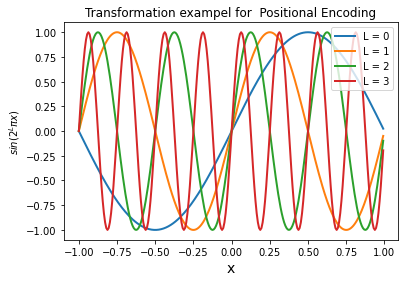

In [54]:
W = 256

x = np.linspace(0, W - 1, W)
x = (x * 1.0 / W) * 2 - 1

L = 4


for el in range(0, L):
    y = np.sin(2 ** el * np.pi * x)
    plt.plot(x, y, label=str('L = {}').format(el), linewidth=2)

plt.title('Transformation exampel for  Positional Encoding')
plt.xlabel('x', fontsize=14)
plt.ylabel('$sin(2^L \pi x$)', fontsize=10)
plt.legend(loc='upper right')
plt.savefig('sin.png', figsize=(10, 5), dpi=100)
plt.show()

In [55]:
! ls nerf_synthetic/lego

test   transforms_test.json   transforms_val.json
train  transforms_train.json  val


In [56]:
root = 'nerf_synthetic/lego'
main = 'transforms_test.json'

In [57]:
ex_dataset = BlenderDataset('nerf_synthetic/lego/', img_wh=[100, 100])
print(f'Number of pixels: {len(ex_dataset)}')

Number of pixels: 1000000


In [58]:
class Embedder(nn.Module):
    """
    Defines a function that embeds x to (x, sin(2^k x), cos(2^k x), ...) 
    (Different from the paper, prepend input 'x' by default)
    Args:
        input_channels (int): number of input channels
        num_freqs (int): `L_d=4` for viewing direcion, `L_x=10` for 3D-coordinate  
        log_scale (bool): 
        First take power of 2 for 0 to 9 and then split equally (log_scale=False) 
        or choose to generate 0-9 first and then take power of 2 separately 
    """

    def __init__(self, input_channels, num_freqs, ):
        super(Embedder, self).__init__()
        self.num_freqs = num_freqs
        self.input_channels = input_channels
        self.encode_fn = [torch.sin, torch.cos]
        self.output_channels = input_channels * \
            (len(self.encode_fn) * num_freqs + 1)
        self.freq_bands = torch.linspace(1, 2 ** (num_freqs-1), num_freqs)

    def forward(self, x):
        """
        Inputs:
            x: (ray_cnt, num_sample, self.in_channels)
        Outputs:
            out: (ray_cnt, num_sample, self.out_channels)
        """
        out = [x]
        for freq in self.freq_bands:
            for func in self.encode_fn:
                out += [func(freq * x)]

        return torch.cat(out, -1)

### Volume Rendering
In this tutorial we are not going to implement volume rendering mechanism, but for general understanding we need to see what and why happening here:
We have many rays passing the scene from different angls. We render the color of any ray passing through the scene using volume rendering. The density $\sigma(x)$  can be interpreted as the differential probability of a
ray terminating at a location x.  The expected color
$C(r)$ of camera ray $r(t) = o + t*d$ ($o$ - from what point and $d$ is the direction of the light) with near and far bounds $t_n$ and $t_f$ is:

$C(\mathbf{r})=\int_{t_{n}}^{t_{f}} T(t) \sigma({r}(t)) {c}({r}(t), {d}) d t$, 
where $T(t)=\exp \left(-\int_{t_{n}}^{t} \sigma({r}(s)) d s\right)$.
Informally $T(t)$ is the probability that the ray goes on and doesn't hit anything,  $\sigma({r}(t))$ shows how much ray stopped at current point and we adopt the color with $c(r(t))$.

The one existing problem here is to compute numerically this integral. For simplicity, we uniformly sample points of depth between near and far bounds. 

![image](https://user-images.githubusercontent.com/20357655/144260820-69d736bc-3dfb-4124-ac84-29d2e5fb7d05.png)

In [59]:
class VolumeRenderer(nn.Module):
    def __init__(
        self,
        train_radiance_field_noise_std=0.0,
        val_radiance_field_noise_std=0.0,
        white_background=False,
        attenuation_threshold=1e-3,
        device='cuda'
    ):
        super(VolumeRenderer, self).__init__()
        self.train_radiance_field_noise_std = train_radiance_field_noise_std
        self.val_radiance_field_noise_std = val_radiance_field_noise_std
        self.attenuation_threshold = attenuation_threshold
        self.use_white_bkg = white_background
        epsilon = torch.tensor([1e10]).to(device)
        epsilon.requires_grad = False
        self.register_buffer("epsilon", epsilon)

    def forward(self, radiance_field, depth_values, ray_directions):
        """
        Perform volume rendering by computing the output of NeRF model ('radiance_field') 
        Inputs:
            radiance_field: (torch.tensor): (ray_count, num_samples, 4) rgb and sigma 
            depth_values:  (torch.tensor): (ray_count, num_samples) : Depths of the sampled positions along the ray
            ray_directions: (torch.tensor): (ray_count, num_samples, 3) 
        Outputs:
            rgb_map: [num_rays, 3]. Estimated RGB color of a ray. Comes from fine model.
        """

        if self.training:
            radiance_field_noise_std = self.train_radiance_field_noise_std
        else:
            radiance_field_noise_std = self.val_radiance_field_noise_std

        # distance between adjacent samples points.
        deltas = torch.cat(
            (
                depth_values[..., 1:] - depth_values[..., :-1],
                self.epsilon.expand(depth_values[..., :1].shape),
            ),
            dim=-1,
        )  # (N_rays, N_samples_)

        # Multiply each distance by the norm (2-norm) of its corresponding direction ray
        # to convert to real world distance (accounts for non-unit directions).
        # (N_rays, N_samples_)
        deltas = deltas * ray_directions[..., None, :].norm(p=2, dim=-1)

        rgb = radiance_field[..., :3]
        noise = 0.0
        if radiance_field_noise_std > 0.0:
            noise = (
                torch.randn(
                    radiance_field[..., 3].shape,
                    dtype=radiance_field.dtype,
                    device=radiance_field.device
                )
                * radiance_field_noise_std
            )  # (ray_count, num_samples)

        sigmas = torch.nn.functional.softplus(radiance_field[..., 3] + noise)

        # Originally  alphas = 1-torch.exp(-deltas*torch.relu(sigmas+noise))
        alpha = 1.0 - torch.exp(-sigmas * deltas)

        # T_i = cumulative-product(j=1,j=(i-1))(1 - alpha_j)
        # (ray_count, num_samples)
        T_i = cumprod_exclusive(1.0 - alpha + 1e-10)

        # weight_i = T_i * alpha_i
        weights = alpha * T_i  # (ray_count, num_samples)
        # (ray_count, num_samples)
        mask_weights = (T_i > self.attenuation_threshold).float()
        rgb_map = weights[..., None] * rgb  # (ray_count, num_samples, 3)

        # sum over rgb value of each sample points (sum_over R,sum_over G, sum_over B) along the ray
        rgb_map = rgb_map.sum(dim=-2)  # (ray_count, 3)

        # sum over weight of each ray
        acc_map = weights.sum(dim=-1)  # (ray_count, )

        depth_map = (weights * depth_values).sum(dim=-1)  # (ray_count, )

        if self.use_white_bkg:
            rgb_map = rgb_map + (1.0 - acc_map[..., None])

        return rgb_map

### NeRF: Implicit 3d scene representation

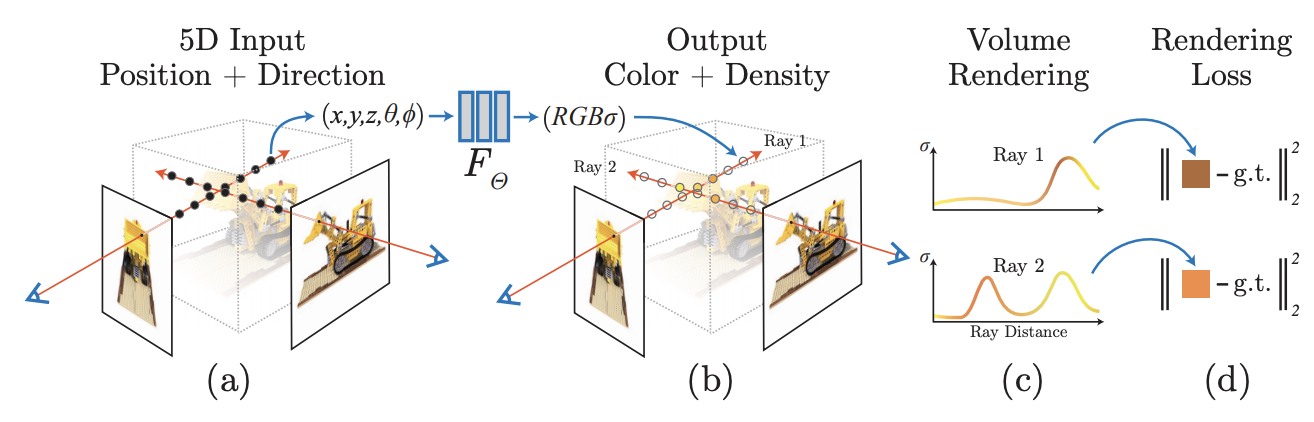

**Nerf Diagram**

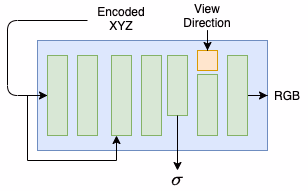

One interesting element here is that we predict the volume density $\sigma$ as a function of only the location x, while allowing the RGB color c to be predicted as a function of both locationand viewing direction. We put in MLP 3D coordinate x with 8 fully-connected layers (with ReLU activations and 256
channels), and outputs $\sigma$ and a 256-dimensional feature vector. This feature vector is then concatenated with the camera ray’s viewing direction and passed to one additional fully-connected layer that output the view-dependent RGB color.

In [60]:
class NeRF(nn.Module):
    def __init__(self,
                 D=8, W=256,
                 in_channels_xyz=63, in_channels_dir=27, 
                 skips=[4]):
        """
        D: number of layers for density (sigma) encoder
        W: number of hidden units in each layer
        in_channels_xyz: number of input channels for xyz (3+3*10*2=63 by default)
        in_channels_dir: number of input channels for direction (3+3*4*2=27 by default)
        skips: add skip connection in the Dth layer
        """
        super(NeRF, self).__init__()
        self.D = D
        self.W = W
        self.in_channels_xyz = in_channels_xyz
        self.in_channels_dir = in_channels_dir
        self.skips = skips

        # xyz encoding layers
        for i in range(D):
            if i == 0:
                layer = nn.Linear(self.in_channels_xyz,  W)
            elif i in skips:
                layer = nn.Linear(self.in_channels_xyz + W,  W)
            else:
                layer = nn.Linear(W,  W)
            layer = nn.Sequential(layer, nn.ReLU(True))
            setattr(self, f"xyz_encoding_{i+1}", layer)
        self.xyz_encoding_final = nn.Linear(W, W)

        # direction encoding layers
        self.dir_encoding = nn.Sequential(
            nn.Linear(self.in_channels_dir + W,  W//2),
            nn.ReLU(True),
        )

        # output layers
        self.sigma = nn.Linear(W, 1)
        self.rgb = nn.Sequential(nn.Linear(W//2, 3),
                                 nn.Sigmoid())

    def forward(self, x, sigma_only=False):
        """
        Encodes input (xyz+dir) to rgb+sigma (not ready to render yet).
        For rendering this ray, please see Renderer.py
        Inputs:
            x: (B, self.in_channels_xyz(+self.in_channels_dir))
               the embedded vector of position and direction
            sigma_only: whether to infer sigma only. If True,
                        x is of shape (B, self.in_channels_xyz)
        Outputs:
            if sigma_only:
                sigma: (B, 1) sigma
            else:
                out: (B, 4), rgb and sigma
        """
        if not sigma_only:
            input_xyz, input_dir = \
                torch.split(x, [self.in_channels_xyz, self.in_channels_dir], dim=-1)
        else:
            input_xyz = x

        xyz_ = input_xyz
        for i in range(self.D):
            if i in self.skips:
                xyz_ = torch.cat([input_xyz, xyz_], -1)
            xyz_ = getattr(self, f"xyz_encoding_{i+1}")(xyz_)

        sigma = self.sigma(xyz_)
        if sigma_only:
            return sigma

        xyz_encoding_final = self.xyz_encoding_final(xyz_)

        dir_encoding_input = torch.cat([xyz_encoding_final, input_dir], -1)
        dir_encoding = self.dir_encoding(dir_encoding_input)
        rgb = self.rgb(dir_encoding)
        out = torch.cat([rgb, sigma], dim=-1)
        return out

In [61]:
class NeRFSystem(LightningModule):
    def __init__(self, hparams):
        super(NeRFSystem, self).__init__()
        self.params = hparams

        self.num_workers = 10
        self.loss = nn.MSELoss(reduction='mean')

        self.embedder_xyz = Embedder(
            input_channels=3,
            num_freqs=10,
        )
        # Question: How many input coord will we have?
        self.embedder_dir = Embedder(
            input_channels=3,
            num_freqs=4,
        )
        self.sampler = RaySampleInterval(hparams['N_samples'],
                                         device=self.device)
        self.embeddings = {'xyz': self.embedder_xyz,
                           'dir': self.embedder_dir,
                           }

        self.models = NeRF(in_channels_xyz=hparams['in_feat'])
        self.img_wh = hparams['img_wh']
        # rendering module
        self.volume_renderer = \
            VolumeRenderer(
                train_radiance_field_noise_std=hparams['noise_std'],
                val_radiance_field_noise_std=0,
                white_background=hparams['white_back'],
                attenuation_threshold=1e-5,
                device=self.device
            )

    def get_progress_bar_dict(self):
        items = super().get_progress_bar_dict()
        items.pop("v_num", None)
        return items

    def forward(self, ray_batch):
        """ Does a prediction for a batch of rays.
        Args:
            x: Tensor of camera rays containing position, direction and bounds.
        Returns: Tensor with the calculated pixel value for each ray.
        """
        def inference(model, embedder_xyz, xyz, embedder_dir, expanded_rays_dir, device):
            """
            Helper function that performs model inference.
            Inputs:
                model: NeRF model (coarse or fine)
                embedder_xyz: embedding module for xyz
                xyz: (N_rays, N_samples_, 3) sampled positions
                    N_samples_ is the number of sampled points in each ray;
                                = N_samples for coarse model
                                = N_samples+N_importance for fine model
                embedder_dir: embedding module for direction
                expanded_rays_dir: (N_rays, N_samples, 3) :expanded ray directions
            Outputs:
                if sigma_only:
                    radience_field:(N_rays, N_samples, 1) 
                else:
                    radience_field:(N_rays, N_samples, 3+1) 
            """
            assert xyz.shape[0] == expanded_rays_dir.shape[0], 'Number of ray differ in coordinate and directions!'
            N_rays = xyz.shape[0]
            assert xyz.shape[1] == expanded_rays_dir.shape[1], 'Number of samples differ in coordinate and directions!'
            N_samples = xyz.shape[1]
            # Flatten the first two dimensions -> (N_rays * N_samples, 3)
            xyz_ = xyz.view(-1, 3)  # (N_rays*N_samples_, 3)
            expanded_rays_dir = expanded_rays_dir.contiguous()
            # (N_rays*N_samples_, 3)
            expanded_rays_dir_ = expanded_rays_dir.view(-1, 3)

            xyz_embedded = embedder_xyz(xyz_)  # (N_rays*N_samples_, 63)
            # (N_rays*N_samples_, 27)
            dir_embedded = embedder_dir(expanded_rays_dir_)

            xyzdir_embedded = torch.cat(
                (xyz_embedded, dir_embedded), dim=-1).to(device)
            radiance_field = model(xyzdir_embedded)
            radiance_field = torch.reshape(
                radiance_field, (N_rays, N_samples, -1)).to(device)
            return radiance_field

        # both (N_rays, N_sample, 3)
        ray_origins, ray_directions = ray_batch[:, 0:3], ray_batch[:, 3:6]
        # both (N_rays, N_sample, 1)
        near, far = ray_batch[:, 6:7], ray_batch[:, 7:8]

        # Generating depth samples
        ray_count = ray_directions.shape[0]
        ray_depth_values = self.sampler(
            ray_count=ray_count,
            near=near,
            far=far,
            lindisp=self.params['lindisp'],
            perturb=self.params['perturb']
        )
        # Samples across each ray (N_rays, N_sample, 3)
        ray_points = intervals_to_ray_points(
            ray_depth_values, ray_directions, ray_origins)

        # Expand rays to match batch size
        expanded_ray_directions = ray_directions[..., None, :].expand_as(
            ray_points)
        # Coarse inference
        coarse_radiance_field = inference(
            model=self.models,
            embedder_xyz=self.embedder_xyz,
            embedder_dir=self.embedder_dir,
            xyz=ray_points,
            expanded_rays_dir=expanded_ray_directions,
            device=self.device
        )
        coarse_rgb = self.volume_renderer(coarse_radiance_field,
                                          ray_depth_values,
                                          ray_directions,
                                          )  # volume rendering

        return coarse_rgb

    def setup(self, stage):
        kwargs = {'root_dir': self.params['root_dir'],
                  'img_wh': tuple(self.img_wh)}

        self.train_dataset = BlenderDataset(split='train', **kwargs)
        self.val_dataset = BlenderDataset(split='val', **kwargs)

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(get_parameters(self.models),
                                          lr=5e-3,
                                          betas=(0.9, 0.999))
        return [self.optimizer]

    def train_dataloader(self):
        return DataLoader(self.train_dataset,
                          shuffle=True,
                          num_workers=self.num_workers,
                          batch_size=self.params['batch_size'],
                          pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset,
                          shuffle=False,
                          num_workers=self.num_workers,
                          # validate one image (H*W rays) at a time
                          batch_size=1,
                          pin_memory=True)

    def training_step(self, batch, batch_nb):
        rays, rgbs = batch['rays'], batch['rgbs']

        results = self.forward(rays)
        loss = self.loss(results, rgbs)

        with torch.no_grad():
            psnr_coarse = psnr(self.loss(results, rgbs))

        self.log('train/loss', loss)
        self.log('train/psnr_coarse', psnr_coarse, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_nb):
        rays, rgbs = batch['rays'], batch['rgbs']
        rays = rays.squeeze()  # (H*W, 3)
        rgbs = rgbs.squeeze()  # (H*W, 3)
        results = self.forward(rays)
        log = {'val_loss': self.loss(results, rgbs)}

        if batch_nb == 0:
            W, H = self.img_wh
            plt.subplot(121)
            plt.imshow(results.view(H, W, 3).cpu().numpy())
            plt.axis('off')
            plt.subplot(122)
            plt.imshow(rgbs.view(H, W, 3).cpu().numpy())
            plt.axis('off')
            plt.show()

        psnr_ = psnr(self.loss(results, rgbs))
        log['val_psnr'] = psnr_

        return log

    def validation_epoch_end(self, outputs):
        mean_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        mean_psnr = torch.stack([x['val_psnr'] for x in outputs]).mean()

        self.log('val/loss', mean_loss)
        self.log('val/psnr', mean_psnr, prog_bar=True)

In [62]:
args = {
    'batch_size': 2400,
    'noise_std': 0,
    'white_back': True, 
    'lindisp': False,
    'perturb': True,
    'in_feat': 63,
    'img_wh': [150, 150],
    'root_dir': 'nerf_synthetic/lego/',
    'N_samples': 64, 

}

In [63]:
system = NeRFSystem(args)

In [65]:
epochs = 1
ckpt_path = None
trainer = Trainer(
    max_epochs=epochs,
    resume_from_checkpoint=ckpt_path,
    gpus=1,
    weights_summary=None,
    progress_bar_refresh_rate=1,
    num_sanity_val_steps=1,
    check_val_every_n_epoch=1,
    benchmark=True,
    profiler="simple",
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [66]:
! nvidia-smi

Wed Dec  1 18:20:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:24:00.0 Off |                  N/A |
| 30%   43C    P8    20W / 350W |      8MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:2D:00.0 Off |                  N/A |
| 44%   

/home/amarkovich/zero10/ml/.venv/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:139: LightningDeprecationWarning: The `LightningModule.get_progress_bar_dict` method was deprecated in v1.5 and will be removed in v1.7. Please use the `ProgressBarBase.get_metrics` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
2021-12-01 18:20:23.338450: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Validation sanity check: 0it [00:00, ?it/s]

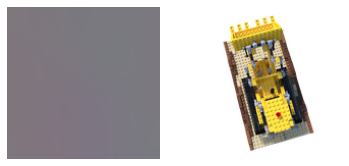

/home/amarkovich/zero10/ml/sandbox/nerf_helper.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -10.0 * torch.log10(torch.tensor(mse, dtype=torch.float32))


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

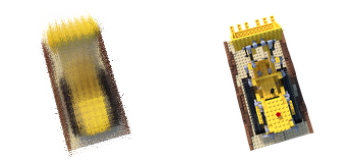

FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  55.69          	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  41.086         	|1              	|  41.086         	|  73.776         	|
run_training_batch                 	|  0.038624       	|938            	|  36.229         	|  65.055         	|
optimizer_step_with_closure_0      	|  0.019387       	|938            	|  18.185         	|  32.653         	|
training_step_and_backward         	|  0.018097       	|938            	|  16.975         	|  30.481         	|
model_forward                      

In [67]:
trainer.fit(system)

In [68]:
torch.save(system.models.state_dict(), 'model.pt')

In [69]:
from IPython.display import HTML
from base64 import b64encode
import imageio
def show_vid(frames, path='video.mp4'):
    imageio.mimwrite(path, frames, fps=30, quality=7)
    mp4 = open(path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
    """ % data_url)

In [70]:
def trans_t(t):
    t = torch.as_tensor(t)
    return torch.tensor([
        [1,0,0,0],
        [0,1,0,0],
        [0,0,1,t],
        [0,0,0,1]], dtype=torch.float)

def rot_phi(phi):
    phi = torch.as_tensor(phi)
    return torch.tensor([
        [1,0,0,0],
        [0,torch.cos(phi),-torch.sin(phi),0],
        [0,torch.sin(phi), torch.cos(phi),0],
        [0,0,0,1]], dtype=torch.float)

def rot_theta(theta):
    theta = torch.as_tensor(theta)
    return torch.tensor([
        [torch.cos(theta),0,-torch.sin(theta),0],
        [0,1,0,0],
        [torch.sin(theta),0, torch.cos(theta),0],
        [0,0,0,1]], dtype=torch.float)

def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = torch.tensor([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]).float() @ c2w
    return c2w


In [71]:

N_SAMPLES = 32
H = W = 150
frames = []
system = system.cuda()
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)

    rays_o, rays_d = get_rays_with_dir(system.train_dataset.dir_cam, c2w[:3, :4])

    near = 2.0
    far = 6.0
    rays = torch.cat([rays_o, rays_d, 
                              near*torch.ones_like(rays_o[:, :1]),
                              far*torch.ones_like(rays_o[:, :1])],
                              1) # (H*W, 8)

    with torch.no_grad():
        rgb = system(rays.cuda())
        # rgb = render_rays(model, rays_o.cuda(), rays_d.cuda(), near=2., far=6., n_samples=N_SAMPLES)
    # frames.append(())
    frames.append((255*np.clip(rgb.view(H, W, 3).cpu().numpy(), 0, 1)).astype(np.uint8))



/tmp/ipykernel_4170824/1522423574.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):


  0%|          | 0/120 [00:00<?, ?it/s]

In [72]:
show_vid(frames) 

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (150, 150) to (160, 160) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x68181c0] Warning: data is not aligned! This can lead to a speed loss


In [ ]:
del frames